## Travel Matching Problem

### Import packages

In [148]:
import json
import re
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import twython
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

### Data Processing & Scoring
processData() takes raw data as an input and gives out a pandas Data Frame after data processing and scoring based on features

In [149]:
def processData():
    sid = SentimentIntensityAnalyzer()
    
    with open('small_analysis_data.json', encoding='utf8') as json_data:
        travel_data = json.load(json_data)
    
    i = 0
    travel_dict = {}

    for tr_pckg in travel_data:
        tr_details_dict = {}

        if tr_pckg.get('address', {}).get('country'):
            usr_country = tr_pckg['address']['country']
        else:
            usr_country = 'NO_COUNTRY'

        if tr_pckg.get('address', {}).get('locality'):
            usr_locality = tr_pckg['address']['locality']
        else:
            usr_locality = 'NO_LOCALITY'

        if tr_pckg.get('address', {}).get('street'):
            usr_street = tr_pckg['address']['street']
        else:
            usr_street = 'NO_STREET'

        if tr_pckg.get('parents'):
            num_of_parents = len(tr_pckg['parents'])
            if num_of_parents > 2:
                usr_place = tr_pckg['parents'][2]
            else:
                usr_place = 'NO_PLACE'
        else:
            usr_place = 'NO_PLACE'

        if tr_pckg.get('name'):
            usr_destination_name = tr_pckg['name']
        else:
            usr_destination_name = 'NO_DESTINATION'

        if tr_pckg.get('category_info', {}).get('category_type'):
            usr_tr_category = tr_pckg['category_info']['category_type']
        else:
            usr_tr_category = 'NO_CATEGORY'

        if tr_pckg.get('category_info', {}).get('category_type'):
            usr_tr_category = tr_pckg['category_info']['category_type'][0]
        else:
            usr_tr_category = 'NO_CATEGORY'

        if tr_pckg.get('category_info', {}).get('sub_category_type'):
            usr_tr_subcategory = tr_pckg['category_info']['sub_category_type'][0]
        else:
            usr_tr_subcategory = 'NO_SUBCATEGORY'

        if tr_pckg.get('star_rating'):
            usr_star_rating = tr_pckg['star_rating']
        else:
            usr_star_rating = 2.5

        if tr_pckg.get('url'):
            usr_url = tr_pckg['url']
        else:
            usr_url = 'NO_URL'

        if tr_pckg.get('num_reviews'):
            usr_num_reviews = tr_pckg['num_reviews']
        else:
            usr_num_reviews = 0

        if tr_pckg.get('inside_city_rank'):
            s = tr_pckg['inside_city_rank']
            its_rank = int(re.findall('\d+', s)[0])
            tot_ranks = int(re.findall('\d+', s)[1])
            usr_inside_city_score = round(1 - its_rank / tot_ranks, 2)
        else:
            usr_inside_city_score = 0

        tr_details_dict['me_country'] = usr_country
        tr_details_dict['me_place'] = usr_place
        tr_details_dict['me_locality'] = usr_locality
        tr_details_dict['me_street'] = usr_street
        tr_details_dict['me_destination'] = usr_destination_name
        tr_details_dict['me_category'] = usr_tr_category
        tr_details_dict['me_sub_category'] = usr_tr_subcategory
        tr_details_dict['usr_star_rating'] = usr_star_rating
        tr_details_dict['me_url'] = usr_url
        tr_details_dict['usr_num_reviews'] = usr_num_reviews
        tr_details_dict['usr_inside_city_score'] = usr_inside_city_score

        if tr_pckg.get('detailed_ratings'):
            for rating, val in tr_pckg['detailed_ratings'].items():
                total = sum(val.values(), 0.0)
                val = {k: round(v / (total + 0.00001), 4) for k, v in val.items()}
                tr_details_dict.update(val)

        if tr_pckg.get('tags'):
            tag_dict = {}
            for tag in tr_pckg['tags']:
                if tag not in tag_dict:
                    tag_dict[tag] = sid.polarity_scores(tag)['compound']
            tr_details_dict.update(tag_dict)

        travel_dict[i] = tr_details_dict
        i += 1
        
    travel_df = pd.DataFrame.from_dict({i: travel_dict[i] for i in travel_dict.keys()}, orient='index')
    travel_df.fillna(0, inplace=True)
    
    return travel_df, travel_dict

In [150]:
travel_df, travel_dict = processData()

### Travel Categorization and Aggregate Scoring

In [151]:
def getCategory(x, category_df):
    return category_df[category_df['MM_ACTIVITIES'] == x]['MM_CATEGORY'].values[0]

def selectScoreColumns(df):
    scoring_columns = []
    for item in df.columns.tolist():
        if re.match('^me_', item):
            pass
        else:
            scoring_columns.append(item)
    return scoring_columns
    
def performCategorization(travel_df):
    category_df = pd.read_csv('Category.csv')
    travel_df['me_travel_category'] = travel_df['me_category'].apply(lambda x: getCategory(x, category_df))
    travel_df = travel_df[travel_df['me_travel_category'] != 'NO_CATEGORY']
    
    scoring_columns = selectScoreColumns(travel_df)
    travel_df['me_aggregate_score'] = travel_df[scoring_columns].apply(lambda x: np.mean(x),  axis = 1) # compute mean score by row
    
    return travel_df

In [152]:
travel_df = performCategorization(travel_df)

C:\Users\Suvro\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Search Algorithm

In [153]:
def findOptimalCluster(similarity_score):
    MAX_K = 10 # to perform the grid search

    total_rec = len(similarity_score)
    X = similarity_score
    
    if total_rec > MAX_K:
        ks = range(1, MAX_K + 1)

        inertias = np.zeros(MAX_K)
        diff = np.zeros(MAX_K)
        diff2 = np.zeros(MAX_K)
        diff3 = np.zeros(MAX_K)

        for k in ks:
            kmeans = KMeans(k).fit(X)
            inertias[k - 1] = kmeans.inertia_
            # first difference    
            if k > 1:
                diff[k - 1] = inertias[k - 1] - inertias[k - 2]
            # second difference
            if k > 2:
                diff2[k - 1] = diff[k - 1] - diff[k - 2]
            # third difference
            if k > 3:
                diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

        elbow = np.argmin(diff3[3:]) + 3

        optimal_num_cluster = ks[elbow]

        plt.plot(ks, inertias, "b*-")
        plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
                 markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
        plt.ylabel("Inertia")
        plt.xlabel("K")
        plt.show()
        
    else:
        optimal_num_cluster = 1    
    
    return optimal_num_cluster

In [154]:
def searchTravel(input_country, input_category, travel_df):
    scoring_columns = selectScoreColumns(travel_df)
    
    search_df = travel_df[travel_df['me_country'].apply(lambda x: x.lower()) == input_country.lower()]
    search_df = search_df[search_df['me_travel_category'].apply(lambda x: x.lower()) == input_category.lower()]
    
    similarity_score = euclidean_distances(search_df[scoring_columns].as_matrix())
    k = findOptimalCluster(similarity_score)
    kmeans = KMeans(k).fit(similarity_score)
    search_df['me_group'] = kmeans.labels_
    
    return search_df, k    

In [155]:
def main(travel_df):
    print(travel_df['me_country'].unique())
    input_country = input('\n Hey where are you going? pls select one from the list ? ')

    if input_country.lower() in [item.lower() for item in travel_df['me_country'].unique()]:
        print('\n')
        print(travel_df['me_travel_category'].unique())
        input_category = input('\n Hey what kind of trip is it ? pls select one from the list ? ')

        if input_category.lower() in [item.lower() for item in travel_df['me_travel_category'].unique()]:
            print('\n Please relax, we will find your next destination')
            print('\n Searching destination ...')

            # Calling the Search Function-
            search_df, k = searchTravel(input_country, input_category, travel_df)
            
            # Start printing---
            
            print('\n\t\t\t\t Country : ', input_country.upper())
            print('\t\t\t\t Category: ', input_category.upper())
            print('\n')
            
            for i in range(k):
                df = search_df[search_df['me_group'] == i]
                df = df.sort_values('me_aggregate_score', ascending=False)
                
                print('\t\tOur recommended travel group: ', input_country.upper(), i+1, '\n')                
                print(df.head()[['me_place', 'me_destination', 'me_category', 'me_sub_category', 'me_aggregate_score']])
                print('\n\n')
            
            print('\n\t Hoorah !!! its time for party, enjoy the recommendations')
        else:
            print('\n I am sure it should be fun, but we are not there yet, please select from the list ')

    else:
        print('\n Sorry we are not there yet, please select the country from the list')

['India' 'Indonesia' 'Malaysia' 'Thailand' 'Singapore']

 Hey where are you going? pls select one from the list ? Thailand


['Adventure' 'Sight-seeing' 'Relaxation']

 Hey what kind of trip is it ? pls select one from the list ? Adventure

 Please relax, we will find your next destination

 Searching destination ...


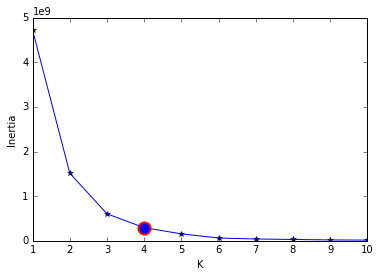


				 Country :  THAILAND
				 Category:  ADVENTURE


		Our recommended travel group:  THAILAND 1 

                 me_place                      me_destination     me_category  \
685  Surat Thani Province               Phangan Bicycle Tours           Tours   
491               Bangkok                   Bangkok Day Tours           Tours   
66                Bangkok  SpiceRoads Cycle Tours - Day Tours           Tours   
684        Krabi Province                    Khlong Dao Beach  Nature & Parks   
350  Surat Thani Province                         Asia Divers           Tours   

        me_sub_category  me_aggregate_score  
685          Bike Tours            0.062808  
491   Sightseeing Tours            0.059529  
66           Bike Tours            0.058783  
684             Beaches            0.056484  
350  Scuba & Snorkeling            0.051840  



		Our recommended travel group:  THAILAND 2 

                 me_place                        me_destination  \
749                Ph

In [156]:
if __name__ == '__main__':
    main(travel_df)